In [1]:
import numpy as np
import pandas as pd
import os

from bs4 import BeautifulSoup
from urllib.request import urlopen
from urllib import parse
import requests
from PIL import Image

from tqdm import tqdm_notebook
import selenium
import nltk
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from eunjeon import Mecab

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dc_db_raw = pd.read_csv('./data/dc_db.csv', encoding='utf-8', index_col=0)
dc_db_raw

,gall_name,cmt_contents
0,baseball_new8,ㅠ.ㅠ
1,baseball_new8,댓글 지우지?
2,baseball_new8,ㅋㅋ
3,baseball_new8,설렁설렁해라 - dc App
4,baseball_new8,Bcaa함 묵으라
5,baseball_new8,자지마라
6,baseball_new8,피부 원툴 - dc App
7,baseball_new8,야리둡 후덕해졌노 ㅋㅋ - dc App
8,baseball_new8,피부도르 수상 ㅋㅋㅋ
9,baseball_new8,왜냐? 즈그 아들 딸들은 이미 졸업했기 때문


In [3]:
len(dc_db_raw['cmt_contents'])

9360

In [4]:
dc_words = ""

for idx in range(len(dc_db_raw['cmt_contents'])):
    dc_words += dc_db_raw['cmt_contents'][idx]
    
dc_words

'ㅠ.ㅠ댓글 지우지?ㅋㅋ설렁설렁해라  - dc AppBcaa함 묵으라자지마라피부 원툴  - dc App야리둡  후덕해졌노 ㅋㅋ  - dc App피부도르 수상 ㅋㅋㅋ왜냐? 즈그 아들 딸들은 이미 졸업했기 때문ㅇㅈ ㅋㅋㅋㅋㅋ 리얼 재앙  - dc App퍄퍄 — (내향성 갤러리 ㄱㄱ)ㅋㅋㅋㅋㅋ 시발남자새끼 지인인데도 그냥 도망가네시발새끼  - dc App시발련아나은아씨는 ㅇㅈ이지노잼diㅋㅋㅋ지랄 ㅋㅋ퍄그걸 왜 붙여 ㅋㅋㅋㅋㅋ  - dc Appㄹㅇㄹㅇ 흠 흠...닮긴했네  - dc App다영이 어제 잘하더라 현건 리시브 병신인데도 꾸역꾸역 토스 잘주더라 ㅋㅋ 직관함ㅋㅋㅋ왜웃노 시발련이  - dc App기사 떴냐누렁아오토호구  - dc App댐비닐이 재활용 되는거 있고 안되는게 있음정석이 퍄백구야흑돌아 밥묵자잉퓨전요리 ㅅㅌㅊ운전자 보험따위론 안대줌  - dc App힝ㅠㅠ시---원ㄷㄷ명란젓이 튀나오노웩아ㅋㅋㅋ나쁜주작불가능분쇄기ㅋㅋㅋ   - dc App나라도 저정도 몸매면 올리고 반응 봄ㄹㅇㅋㅋㄹㅇ질투하농 ㅋㅋ여기에 여자 못 만나본 새끼들 천지라질투하농 ㅋㅋ여기에 여자 못 만나본 새끼들 천지라농어누나 ㅋㅋㅋㅋ각선미 예쁜 애들 많음http://m.dcinside.com/board/baseball_new8/7569505개추ㄱㄱ그거 우리학교도 있는데 ㅅㅂㅋㅋㅋ  - dc App분량 몰아준것도 그렇고지들이뽑는게 아니라 접대해서 뽑힌거잖어ㅋㅋ말투가 기음갤에서 보던 줫같은 말투인데나도 맞아보고싶네크리넥스 한통 바꿔줌일기를 써놨노 힘내라ㄹㅇ ㅋㅋ팩트다보빨 새끼들 반응보면 퇴물은 아닌거 같음ㅋㅋ솔직히 결혼할여자로선 ㅎㅌㅊ 이제 맘도아닌데 맘은빼야되는거 아니노 ㅋㅋ  - dc App돌싱\'맘\'이자너ㅋㅋ돼지들이 또  - dc Appㄷㄷ  - dc Appㅋㅋㅋㅋㄴ  - dc AppPornhub에 쯔위랑 모모 있음진짠줄 알았잖아  - dc Appㄷㄷㄷㄷㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ괴물이 되버렸노ㅋㅋ참된 어머니네이거 연말시상식 시즌에

In [5]:
mecab = Mecab()
dc_words = mecab.nouns(dc_words)
dc_words

['피부',
 '원',
 '툴',
 '야리',
 '둡',
 '후덕',
 '피부',
 '르',
 '수상',
 '즈그',
 '아들',
 '딸',
 '졸업',
 '때문',
 '리얼',
 '재앙',
 '내향성',
 '갤러리',
 'ㄱ',
 'ㄱ',
 '시발',
 '남자',
 '새끼',
 '지인',
 '시발',
 '새끼',
 '시발',
 '은아',
 '씨',
 '지랄',
 '그걸',
 '다영',
 '건',
 '리시브',
 '병신',
 '토스',
 '직관',
 '시',
 '발련',
 '기사',
 '누렁',
 '아오토',
 '호구',
 '댐',
 '비닐',
 '활용',
 '거',
 '게',
 '정석',
 '밥',
 '묵자',
 '잉',
 '퓨전',
 '요리',
 'ㅅ',
 '보험',
 '따위',
 '힝',
 '원',
 'ㄷ',
 'ㄷ',
 '명란젓',
 '튀',
 '나',
 '나라',
 '정도',
 '몸매',
 '반응',
 '봄',
 '여기',
 '여자',
 '새끼',
 '천지',
 '질투',
 '하농',
 '여기',
 '여자',
 '새끼',
 '천지',
 '농어',
 '누나',
 '각선미',
 '애',
 '개추',
 'ㄱ',
 'ㄱ',
 '그거',
 '우리',
 '학교',
 'ㅅ',
 'ㅂ',
 '분량',
 '것',
 '지',
 '게',
 '접대',
 '거',
 '말투',
 '기음',
 '갤',
 '말투',
 '나',
 '크리넥스',
 '통',
 '일기',
 '새끼',
 '반응',
 '퇴물',
 '거',
 '결혼',
 '여자',
 '맘',
 '맘',
 '거',
 '돌',
 '싱',
 '맘',
 '너',
 '돼지',
 'ㄷ',
 'ㄷ',
 'ㄴ',
 '위',
 '모모',
 '진짠',
 '줄',
 'ㄷ',
 'ㄷ',
 'ㄷ',
 'ㄷ',
 '괴물',
 '참',
 '어머니',
 '이거',
 '연말',
 '시상식',
 '시즌',
 '이거',
 '연말',
 '시상식',
 '시즌',
 '거',
 '다리',
 '밑',
 '농어',
 '다희',
 '다희',
 '눈',
 '나',
 '고

In [6]:
ko = nltk.Text(dc_words, name='디씨 텍스트')
ko.vocab().most_common(100)

[('거', 1343),
 ('게', 348),
 ('새끼', 275),
 ('내', 258),
 ('말', 257),
 ('ㅅ', 252),
 ('ㄴ', 247),
 ('나', 243),
 ('수', 234),
 ('것', 219),
 ('병신', 211),
 ('ㄷ', 200),
 ('ㅂ', 198),
 ('건', 184),
 ('좆', 182),
 ('애', 180),
 ('때', 177),
 ('개', 175),
 ('ㄱ', 173),
 ('너', 160),
 ('년', 158),
 ('글', 153),
 ('듯', 147),
 ('일', 143),
 ('사람', 143),
 ('생각', 139),
 ('데', 132),
 ('전', 117),
 ('씹', 112),
 ('뭐', 111),
 ('갤', 110),
 ('한국', 110),
 ('놈', 108),
 ('정도', 104),
 ('니', 104),
 ('ㅈ', 100),
 ('걸', 99),
 ('시발', 97),
 ('번', 95),
 ('돈', 95),
 ('그거', 91),
 ('소리', 89),
 ('자살', 87),
 ('만', 86),
 ('겜', 86),
 ('방사능', 85),
 ('이', 84),
 ('똥', 82),
 ('방송', 82),
 ('여기', 81),
 ('줄', 81),
 ('중', 80),
 ('게임', 78),
 ('지', 77),
 ('그게', 77),
 ('이거', 75),
 ('가능', 72),
 ('이상', 71),
 ('누가', 71),
 ('라인', 70),
 ('지랄', 69),
 ('대표', 68),
 ('난', 68),
 ('페이커', 68),
 ('문제', 66),
 ('왜구', 66),
 ('유승민', 64),
 ('원', 62),
 ('여자', 62),
 ('뭘', 62),
 ('피지컬', 62),
 ('일본', 62),
 ('그건', 60),
 ('명', 60),
 ('자기', 60),
 ('병', 60),
 ('시간', 59),
 ('

In [7]:
len(dc_words)
len(set(dc_words))

6342

In [10]:
#stop_words = ['이','는','하','고','다','은','을','에','가','-','의','들',
#              '도',',','/','한','있','지','를']
stop_words = []

In [11]:
tokens_ko = [each_word for each_word in dc_words if each_word not in stop_words]

ko = nltk.Text(tokens_ko, name='디씨 텍스트')
ko.vocab().most_common(100)

[('거', 1343),
 ('게', 348),
 ('새끼', 275),
 ('내', 258),
 ('말', 257),
 ('ㅅ', 252),
 ('ㄴ', 247),
 ('나', 243),
 ('수', 234),
 ('것', 219),
 ('병신', 211),
 ('ㄷ', 200),
 ('ㅂ', 198),
 ('건', 184),
 ('좆', 182),
 ('애', 180),
 ('때', 177),
 ('개', 175),
 ('ㄱ', 173),
 ('너', 160),
 ('년', 158),
 ('글', 153),
 ('듯', 147),
 ('일', 143),
 ('사람', 143),
 ('생각', 139),
 ('데', 132),
 ('전', 117),
 ('씹', 112),
 ('뭐', 111),
 ('갤', 110),
 ('한국', 110),
 ('놈', 108),
 ('정도', 104),
 ('니', 104),
 ('ㅈ', 100),
 ('걸', 99),
 ('시발', 97),
 ('번', 95),
 ('돈', 95),
 ('그거', 91),
 ('소리', 89),
 ('자살', 87),
 ('만', 86),
 ('겜', 86),
 ('방사능', 85),
 ('이', 84),
 ('똥', 82),
 ('방송', 82),
 ('여기', 81),
 ('줄', 81),
 ('중', 80),
 ('게임', 78),
 ('지', 77),
 ('그게', 77),
 ('이거', 75),
 ('가능', 72),
 ('이상', 71),
 ('누가', 71),
 ('라인', 70),
 ('지랄', 69),
 ('대표', 68),
 ('난', 68),
 ('페이커', 68),
 ('문제', 66),
 ('왜구', 66),
 ('유승민', 64),
 ('원', 62),
 ('여자', 62),
 ('뭘', 62),
 ('피지컬', 62),
 ('일본', 62),
 ('그건', 60),
 ('명', 60),
 ('자기', 60),
 ('병', 60),
 ('시간', 59),
 ('

In [12]:
path = 'c:/Windows/Fonts/malgun.ttf'
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname=path).get_name()
rc('font', family=font_name)

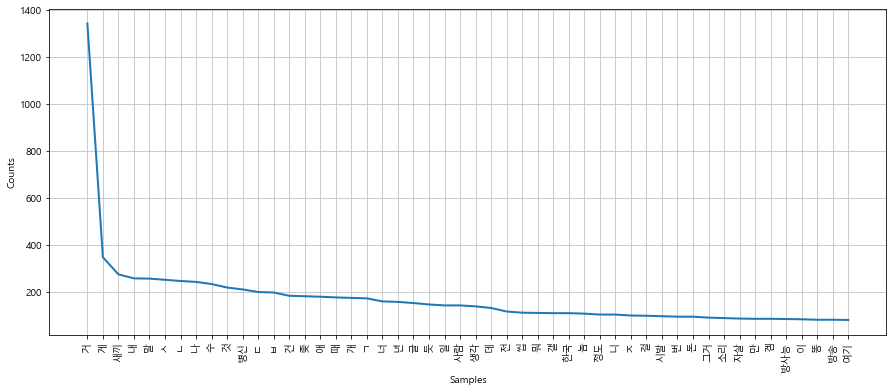

In [13]:
plt.figure(figsize=(15,6))
ko.plot(50)
plt.show()

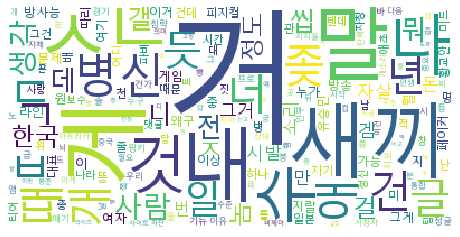

In [14]:
data = ko.vocab().most_common(300)
wordcloud = WordCloud(font_path=path,
                      relative_scaling=0.5,
                      stopwords=stop_words,
                      background_color = 'white').generate_from_frequencies(dict(data))
plt.figure(figsize=(8,6))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# 네이버 영화리뷰 전처리 및 분석

## - 데이터 불러오기 및 분석하기

In [15]:
DATA_IN_PATH = './data/'
print('파일크기 : ')
for file in os.listdir(DATA_IN_PATH):
    if 'txt' in file :
        print(file.ljust(30) + str(round(os.path.getsize('./data/' + file) / 1000000, 2)) + 'MB')

파일크기 : 
ratings.txt                   19.52MB
ratings_test.txt              4.89MB
ratings_train.txt             14.63MB


In [16]:
import re
import json
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer

train_data = pd.read_csv('./data/ratings_train.txt', header = 0, delimiter='\t', quoting = 3)
train_data

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


In [17]:
print('전체 학습데이터 개수 : ', len(train_data))

전체 학습데이터 개수 :  150000


In [18]:
train_length = train_data['document'].astype(str).apply(len)
train_length.head()

0    19
1    33
2    17
3    29
4    61
Name: document, dtype: int64

Text(0, 0.5, 'Number of review')

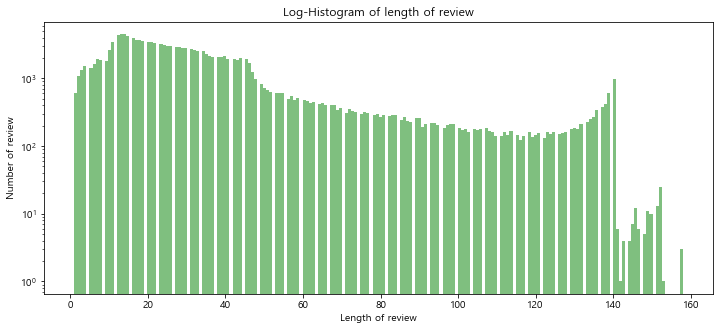

In [19]:
# 그래프
plt.figure(figsize=(12,5))
plt.hist(train_length, bins=200, alpha=0.5, color='g', label='word')
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of length of review')
plt.xlabel('Length of review')
plt.ylabel('Number of review')

In [20]:
print('리뷰 길이 최댓값 ', np.max(train_length))
print('리뷰 길이 최솟값 ', np.min(train_length))
print('리뷰 길이 평균값 ', np.mean(train_length))
print('리뷰 길이 표준편차 ', np.std(train_length))
print('리뷰 길이 중간값 ', np.median(train_length))
print('리뷰 길이 제1사분위 ', np.percentile(train_length, 25))
print('리뷰 길이 제3사분위 ', np.percentile(train_length, 75))

리뷰 길이 최댓값  158
리뷰 길이 최솟값  1
리뷰 길이 평균값  35.23749333333333
리뷰 길이 표준편차  29.582262651516178
리뷰 길이 중간값  27.0
리뷰 길이 제1사분위  16.0
리뷰 길이 제3사분위  42.0


{'whiskers': [<matplotlib.lines.Line2D at 0x1e742937b38>,
 'caps': [<matplotlib.lines.Line2D at 0x1e742928208>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e742937908>],
 'medians': [<matplotlib.lines.Line2D at 0x1e742928898>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e742928ef0>],
 'means': [<matplotlib.lines.Line2D at 0x1e742928be0>]}

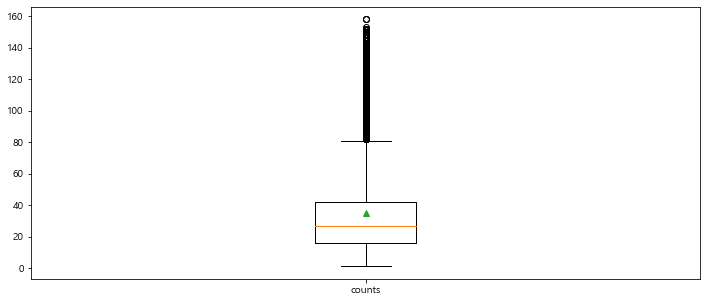

In [21]:
plt.figure(figsize=(12,5))
plt.boxplot(train_length, labels=['counts'], showmeans=True)

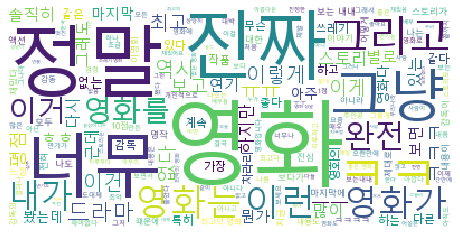

In [22]:
train_review = [review for review in train_data['document'] if type(review) is str]
wordcloud = WordCloud(font_path=path,
                      relative_scaling=0.5,
                      background_color = 'white').generate(' '.join(train_review))
plt.figure(figsize=(8,6))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

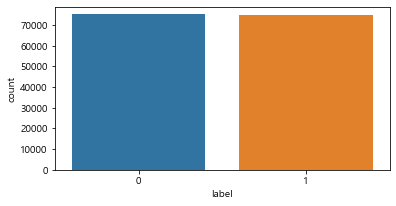

In [23]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(6, 3)
sns.countplot(train_data['label'])

In [24]:
print('긍정 리뷰 개수', train_data['label'].value_counts()[1])
print('주정 리뷰 개수', train_data['label'].value_counts()[0])

긍정 리뷰 개수 74827
주정 리뷰 개수 75173


Text(0.5, 0, 'Number of reviews')

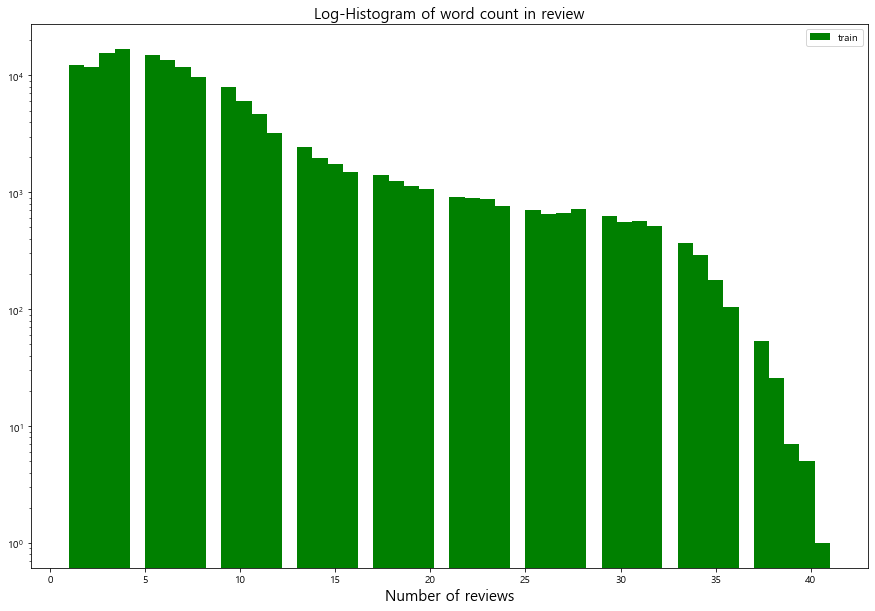

In [25]:
train_word_counts = train_data['document'].astype(str).apply(lambda x:len(x.split(' ')))

plt.figure(figsize=(15, 10))
plt.hist(train_word_counts, bins=50, facecolor='g', label='train')
plt.title('Log-Histogram of word count in review', fontsize=15)
plt.yscale('log', nonposy='clip')
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.xlabel('Number of reviews', fontsize=15)

In [26]:
print('리뷰 단어 개수 최댓값 ', np.max(train_word_counts))
print('리뷰 단어 개수 최솟값 ', np.min(train_word_counts))
print('리뷰 단어 개수 평균값 ', np.mean(train_word_counts))
print('리뷰 단어 개수 표준편차 ', np.std(train_word_counts))
print('리뷰 단어 개수 중간값 ', np.median(train_word_counts))
print('리뷰 단어 개수 제1사분위 ', np.percentile(train_word_counts, 25))
print('리뷰 단어 개수 제3사분위 ', np.percentile(train_word_counts, 75))

리뷰 단어 개수 최댓값  41
리뷰 단어 개수 최솟값  1
리뷰 단어 개수 평균값  7.58494
리뷰 단어 개수 표준편차  6.514041131514803
리뷰 단어 개수 중간값  6.0
리뷰 단어 개수 제1사분위  3.0
리뷰 단어 개수 제3사분위  9.0


In [27]:
qmark = np.mean(train_data['document'].astype(str).apply(lambda x: '?' in x))
fullstop = np.mean(train_data['document'].astype(str).apply(lambda x: '.' in x))

print('물음표가 잇는 질문 : ', qmark*100)
print('마침표가 잇는 질문 : ', fullstop*100)

물음표가 잇는 질문 :  8.247333333333334
마침표가 잇는 질문 :  51.76333333333333


## - 데이터 전처리

In [28]:
from konlpy.tag import Okt

In [29]:
def preprocessing(data, okt, remove_stopwords = False, stop_words=[]):
    data_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", data)
    words = okt.morphs(data_text, stem=True)
    
    if remove_stopwords:
        words = [token for token in words if not token in stop_words]

    return words

In [30]:
okt = Okt()

stop_words = set(['은', '는', '이', '가', '하', '아', '것',
                  '들', '의', '있', '되', '수', '보', '주',
                  '등', '한'])

clean_train_review = []

C:\Users\VI\Anaconda3\envs\badWord\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


In [31]:
for review in tqdm_notebook(train_data['document']):
    if type(review) == str:
        clean_train_review.append(preprocessing(review, okt, remove_stopwords=True,
                                                stop_words=stop_words))
    else:
        clean_train_review.append([])

C:\Users\VI\Anaconda3\envs\badWord\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [32]:
clean_train_review[:4]

[['더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다'],
 ['교도소', '이야기', '구먼', '솔직하다', '재미', '없다', '평점', '조정']]

In [33]:
test_data = pd.read_csv('./data/ratings_test.txt', header=0, delimiter='\t', quoting = 3)
clean_test_review = []

In [34]:
for review in tqdm_notebook(test_data['document']):
    if type(review) == str:
        clean_test_review.append(preprocessing(review, okt, remove_stopwords=True,
                                                stop_words=stop_words))
    else:
        clean_test_review.append([])

C:\Users\VI\Anaconda3\envs\badWord\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [35]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_review)
train_sequences = tokenizer.texts_to_sequences(clean_train_review)
test_sequences = tokenizer.texts_to_sequences(clean_test_review)

word_vocab = tokenizer.word_index

In [36]:
MAX_SEQUENCE_LENGTH = 12

train_inputs = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
train_labels = np.array(train_data['label'])

test_inputs = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
test_labels = np.array(test_data['label'])

In [37]:
data_configs = {}

data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab)

# 학습데이터 벡터화 및 라벨
np.save(open('./data/word_dict/nsmc_train_input.npy', 'wb'), train_inputs)
np.save(open('./data/word_dict/nsmc_train_label.npy', 'wb'), train_labels)

# 평가데이터 벡터화 및 라벨
np.save(open('./data/word_dict/nsmc_test_input.npy', 'wb'), test_inputs)
np.save(open('./data/word_dict/nsmc_test_label.npy', 'wb'), test_labels)

# 데이터 사전을 json 형태로 저장
json.dump(data_configs, open('./data/word_dict/data_configs.json', 'w'), ensure_ascii=False)

In [38]:
len(word_vocab)

43756

In [39]:
train_inputs.shape

(150000, 12)

In [40]:
test_inputs[3]

array([ 73,  24,  92, 344, 115, 109,  67, 154, 281,   0,   0,   0])

In [41]:
clean_train_review[3]

['교도소', '이야기', '구먼', '솔직하다', '재미', '없다', '평점', '조정']

In [43]:
test_inputs[3]

array([ 73,  24,  92, 344, 115, 109,  67, 154, 281,   0,   0,   0])